# Seam Carving Tutorial

In [9]:
# Import libraries

%matplotlib inline
%pprint off

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import io, color, img_as_ubyte
from scipy.ndimage.filters import sobel

Pretty printing has been turned OFF


In [ ]:
# Function to ...

In [ ]:
# Function to ...

In [2]:
# Function to find the energy of the image
def get_energy(img):
    # Convert image to greyscale
    gray = color.rgb2grey(img)
    # Convert to uint8
    gray = img_as_ubyte(gray)
    # return sobel image
    energy = sobel(gray)
    return energy

In [15]:
# Function to find the lowest energy seam
def get_seam(img, energy):
    # Get the number of rows and columns of the image
    rows = img.shape[0]
    cols = img.shape[1]

    # Create the seam array
    seam = np.zeros(rows, dtype='u8')

    # Matrix to compute the cumulative energy 
    cumulEnergy = np.zeros([rows,cols]) + img.size
    cumulEnergy[0,:] = np.zeros(cols, dtype='u8')
    
    # Matrix to save the path from each pixel to one of the below 3-neighboor pixels (1,0,-1)
    path = np.zeros([rows,cols])

    # Compute the cumulative energy and path matrices
    for row in range(rows-1):
        for col in range(cols):
            if col != 0:
                if cumulEnergy[row+1,col-1] > cumulEnergy[row,col] + energy[row+1,col-1]:
                    cumulEnergy[row+1,col-1] = cumulEnergy[row,col] + energy[row+1,col-1]
                    path[row+1,col-1] = 1

            if cumulEnergy[row+1,col] > cumulEnergy[row,col] + energy[row+1,col]:
                cumulEnergy[row+1,col] = cumulEnergy[row,col] + energy[row+1,col]
                path[row+1,col] = 0

            if col != cols-1:
                if cumulEnergy[row+1,col+1] > cumulEnergy[row,col] + energy[row+1,col+1]:
                    cumulEnergy[row+1,col+1] = cumulEnergy[row,col] + energy[row+1,col+1]
                    path[row+1,col+1] = -1

    # Get the column in last row with lowest cummulative energy
    seam[rows-1] = np.argmin(cumulEnergy[rows-1,:])
    
    # Fill up the seam array by bactracking from bottom to top
    for i in range(rows-1,0,-1):
        seam[i-1] = seam[i] + path[i, seam[i]]
    
    return seam

In [4]:
# Function to draw the seam on the image
def draw_seam(img, seam):
    imgSeam = np.copy(img)

    for i,j in enumerate(seam):
        imgSeam[i,j] = (250,0,0)
        
    return imgSeam

In [5]:
# Function to remove the seam from the image
def carve_seam(img, seam):
    # Get the number of rows and columns of the image
    rows = img.shape[0]
    cols = img.shape[1]
    
    # For every seam pixel, shift the pixels located on the same row on the right to the left by 1 position
    for r in range(rows):
        for c in range(int(seam[r]), cols - 1):
            img[r,c] = img[r,c+1]

    # Return the image without the last column
    return img[:,:cols - 1]

C:\Programs\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


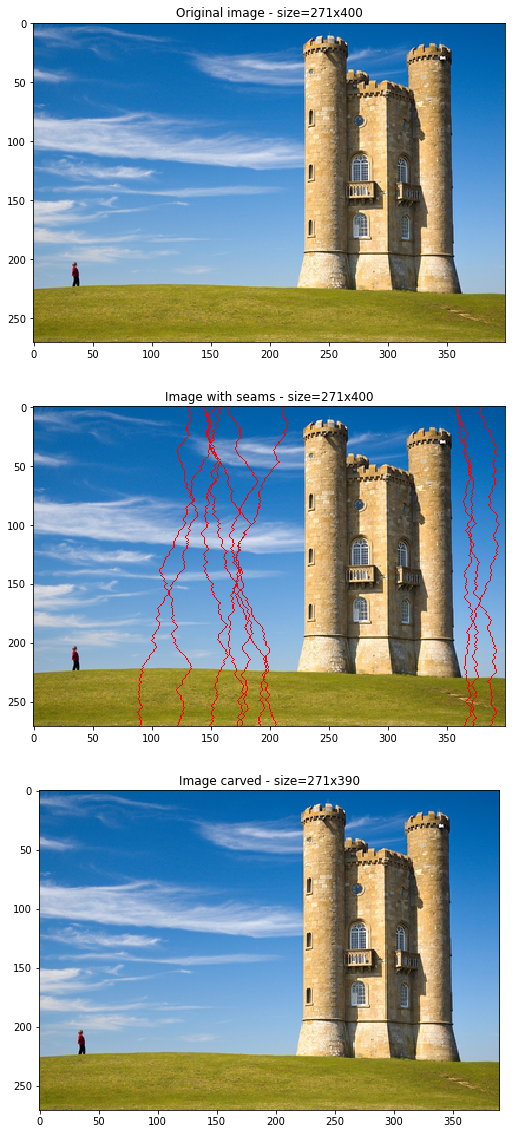

In [17]:
# Import image
img = io.imread('./test.jpg')

# Number of seams to delete
totalSeams = 10

# Image to display detected seams
imgSeams = np.copy(img)

# Image to be carved
imgCarved = np.copy(img)

# Iteratively find the seam with lowest energy and remove it
for i in range(totalSeams):
    energy = get_energy(imgCarved)
    seam = get_seam(imgCarved, energy)
    imgSeams = draw_seam(imgSeams, seam)
    imgCarved = carve_seam(imgCarved, seam)

    
# Daw the images
fig, axes= plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
ax0, ax1, ax2 = axes.ravel()

ax0.imshow(img)
ax0.set_title('Original image - size={}x{}'.format(img.shape[0],img.shape[1]))

ax1.imshow(imgSeams)
ax1.set_title('Image with seams - size={}x{}'.format(imgSeams.shape[0],imgSeams.shape[1]))

ax2.imshow(imgCarved)
ax2.set_title('Image carved - size={}x{}'.format(imgCarved.shape[0],imgCarved.shape[1]))